# Stability calculations

## -- LUVOIR --

In notebook 10, we calculated the PASTIS modes for all three currently designed apodizers for the LUVOIR A pupil. In this notebook, we will load the modes and calculate the maximum mode contributions $\sigma$ and strability requirements $\Delta \sigma$.

After that I also calculate the maximum segment contributions $\mu$.

In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from astropy.io import fits
import astropy.units as u
import hcipy as hc

os.chdir('../../pastis/')
import util_pastis as util
from e2e_simulators.luvoir_imaging_new import LuvoirAPLC

In [2]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Computer Modern Sans"]
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 16

## Instantiate a simple SM for mode plotting

I need to simplify this... I can make a child class like I did for the full LUVOIR simulator.

In [4]:
# Load aperture files needed for SM
nseg = 120
wvln = 638e-9

datadir = '/Users/pueyo/PythonPackages/PASTIS/LUVOIR_delivery_May2019/'
aper_path = 'inputs/TelAp_LUVOIR_gap_pad01_bw_ovsamp04_N1000.fits'
aper_ind_path = 'inputs/TelAp_LUVOIR_gap_pad01_bw_ovsamp04_N1000_indexed.fits'
aper_read = hc.read_fits(os.path.join(datadir, aper_path))
aper_ind_read = hc.read_fits(os.path.join(datadir, aper_ind_path))

pupil_grid = hc.make_pupil_grid(dims=aper_ind_read.shape[0], diameter=15)
aper = hc.Field(aper_read.ravel(), pupil_grid)
aper_ind = hc.Field(aper_ind_read.ravel(), pupil_grid)

wf_aper = hc.Wavefront(aper, wvln)

# Load segment positions from fits header
hdr = fits.getheader(os.path.join(datadir, aper_ind_path))

poslist = []
for i in range(nseg):
    segname = 'SEG' + str(i+1)
    xin = hdr[segname + '_X']
    yin = hdr[segname + '_Y']
    poslist.append((xin, yin))
    
poslist = np.transpose(np.array(poslist))
seg_pos = hc.CartesianGrid(hc.UnstructuredCoords(poslist))

## Mode and eigenvalue units

Since the matrices got generated normalized to an aberration of 1 nm, everything stemming from the matrix will be in units of **nanometers**. --> This is the desired behaviour of course and is yet to be confirmed, which is one of the goals of this notebook.

In [5]:
eunit = 1e-9

## Also instantiate a LUVOR telescope

For cumulative contrast calculation.

> **ATTENTION:** the variable `apodizer_design` has to be correct for the data we are reading with the variable `savedpath` further below!!!

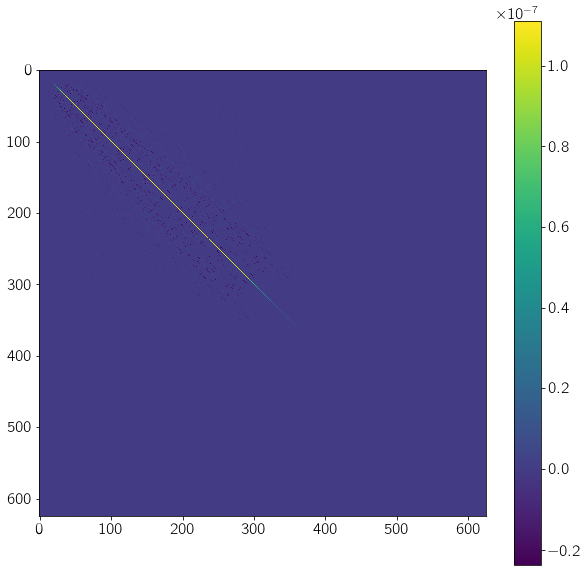

In [6]:
savedpath = '/Users/pueyo/Documents/data_from_repos/pastis_data/2020-08-10T19-58-29_luvoir-medium'   # large apodizer LUVOIR
matrix = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'PASTISmatrix_num_Multiple_Modes_HI_25.fits'))
plt.figure(figsize=(10, 10))
plt.imshow(matrix)
plt.colorbar()

In [10]:
# Instantiate LUVOIR
sampling = 4
apodizer_design = 'medium'
# This path is specific to the paths used in the LuvoirAPLC class
optics_input = '/Users/pueyo/PythonPackages/PASTIS/LUVOIR_delivery_May2019/'
luvoir = LuvoirAPLC(optics_input, apodizer_design, sampling)

/Users/pueyo/anaconda3/envs/pastis-new-hcipy/lib/python3.7/site-packages/hcipy/field/cartesian_grid.py:68: UserWarning: No automatic weights could be calculated for this grid.
  self.weights *= np.abs(scale)**self.ndim


In [11]:
N_four = 25

In [12]:
luvoir.make_HI_Modes(N_four)

In [9]:
# jo = hc.make_pupil_grid(dims=N_four, diameter=N_four)
# mas =  hc.mode_basis.make_fourier_basis(luvoir.pupil_grid, jo, sort_by_energy=True)
# gru = hc.optics.DeformableMirror(mas)

In [ ]:
# oh = mas.transformation_matrix
# ih = oh[:,2].reshape([1000,1000])
# plt.imshow(ih)

In [13]:
eunit = 1e-9

In [14]:
zernike_coeffs = np.zeros([luvoir.fdm.num_actuators])
zernike_coeffs[4] = 0
luvoir.fdm.actuators = zernike_coeffs
psf_unaber, ref = luvoir.calc_psf(ref=True)
norm = ref.max()
# wf_sm = gru(luvoir.wf_aper)
# psf_unaber, ref = luvoir.calc_psf(ref=True)
# norm = ref.max()

In [16]:
zernike_coeffs = np.zeros([luvoir.fdm.num_actuators])
zernike_coeffs[624] = eunit
luvoir.fdm.actuators = zernike_coeffs
psf_abber, ref = luvoir.calc_psf(ref=True)
norm = ref.max()

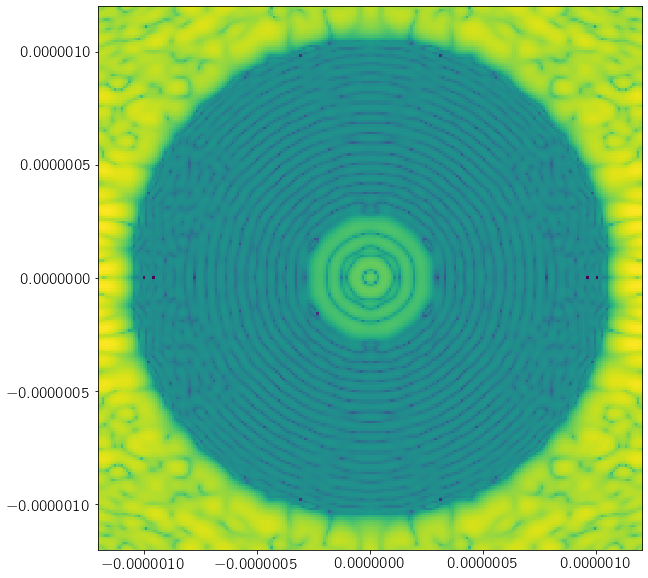

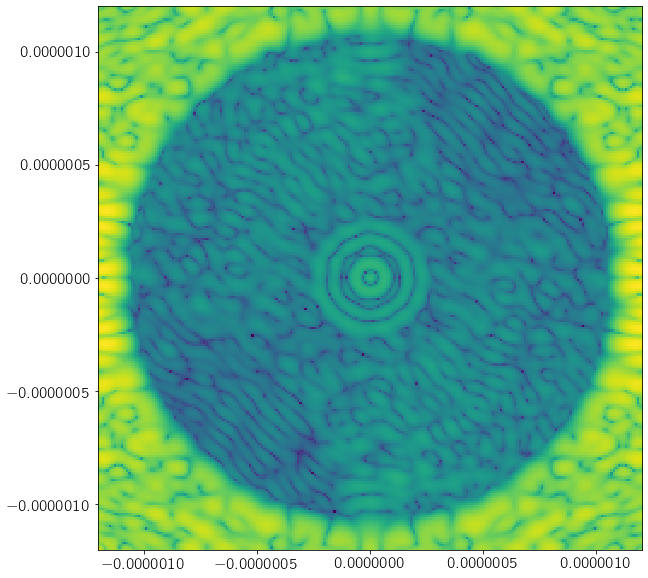

In [17]:
plt.figure(figsize=(10, 10))
hc.imshow_field(psf_unaber, norm=LogNorm())
plt.figure(figsize=(10, 10))
hc.imshow_field(psf_abber, norm=LogNorm())

In [18]:
# Make dark hole
dh_outer = hc.circular_aperture(2*luvoir.apod_dict[apodizer_design]['owa'] * luvoir.lam_over_d)(luvoir.focal_det)
dh_inner = hc.circular_aperture(2*luvoir.apod_dict[apodizer_design]['iwa'] * luvoir.lam_over_d)(luvoir.focal_det)
dh_mask = (dh_outer - dh_inner).astype('bool')

In [19]:
dh_intensity = psf_unaber/norm * dh_mask
baseline_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)])
print('contrast:', baseline_contrast)

contrast: 3.924822663883738e-11


## Read eigenmodes and eigenvalues

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


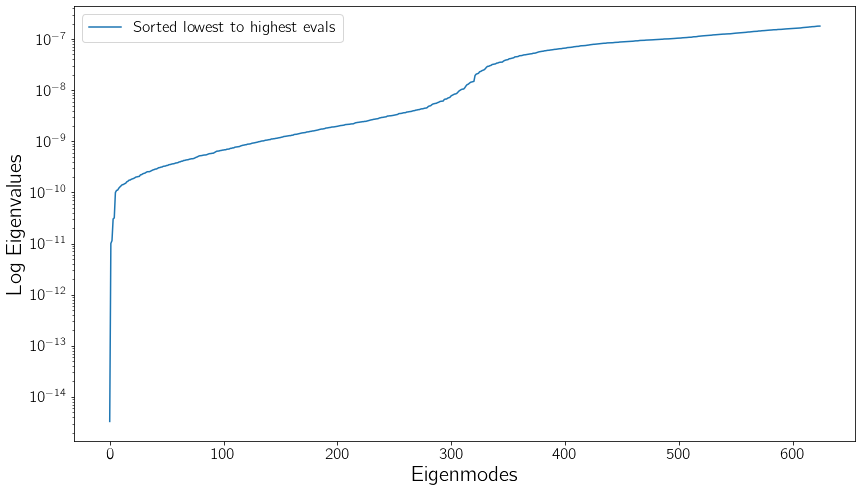

In [20]:
evals, evecs = np.linalg.eig(matrix)
sorted_evals = np.sort(evals)
sorted_indices = np.argsort(evals)
sorted_evecs = evecs[:, sorted_indices]
plt.figure(figsize=(14, 8))
#plt.plot(evals, label='Unsorted from eigendecomposition')
plt.plot(sorted_evals, label='Sorted lowest to highest evals')
plt.semilogy()
plt.xlabel('Eigenmodes')
plt.ylabel('Log Eigenvalues')
plt.legend()

In [22]:
# Lets compute all modes now for LUVOIR with an HCIPy SM
emodes = []

for mode in range(len(evals)):
    print('Working on mode {}/{}.'.format(mode+1, len(evals)))
    
    zernike_coeffs = eunit*sorted_evecs[:, mode]/2
    luvoir.fdm.actuators = zernike_coeffs
    wf_sm = luvoir.fdm(luvoir.wf_aper)
    emodes.append(wf_sm.phase)

Working on mode 1/625.
Working on mode 2/625.
Working on mode 3/625.
Working on mode 4/625.
Working on mode 5/625.
Working on mode 6/625.
Working on mode 7/625.
Working on mode 8/625.
Working on mode 9/625.
Working on mode 10/625.
Working on mode 11/625.
Working on mode 12/625.
Working on mode 13/625.
Working on mode 14/625.
Working on mode 15/625.
Working on mode 16/625.
Working on mode 17/625.
Working on mode 18/625.
Working on mode 19/625.
Working on mode 20/625.
Working on mode 21/625.
Working on mode 22/625.
Working on mode 23/625.
Working on mode 24/625.
Working on mode 25/625.
Working on mode 26/625.
Working on mode 27/625.
Working on mode 28/625.
Working on mode 29/625.
Working on mode 30/625.
Working on mode 31/625.
Working on mode 32/625.
Working on mode 33/625.
Working on mode 34/625.
Working on mode 35/625.
Working on mode 36/625.
Working on mode 37/625.
Working on mode 38/625.
Working on mode 39/625.
Working on mode 40/625.
Working on mode 41/625.
Working on mode 42/625.
W

Working on mode 334/625.
Working on mode 335/625.
Working on mode 336/625.
Working on mode 337/625.
Working on mode 338/625.
Working on mode 339/625.
Working on mode 340/625.
Working on mode 341/625.
Working on mode 342/625.
Working on mode 343/625.
Working on mode 344/625.
Working on mode 345/625.
Working on mode 346/625.
Working on mode 347/625.
Working on mode 348/625.
Working on mode 349/625.
Working on mode 350/625.
Working on mode 351/625.
Working on mode 352/625.
Working on mode 353/625.
Working on mode 354/625.
Working on mode 355/625.
Working on mode 356/625.
Working on mode 357/625.
Working on mode 358/625.
Working on mode 359/625.
Working on mode 360/625.
Working on mode 361/625.
Working on mode 362/625.
Working on mode 363/625.
Working on mode 364/625.
Working on mode 365/625.
Working on mode 366/625.
Working on mode 367/625.
Working on mode 368/625.
Working on mode 369/625.
Working on mode 370/625.
Working on mode 371/625.
Working on mode 372/625.
Working on mode 373/625.


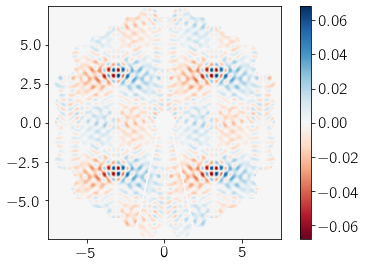

In [48]:
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(emodes[10],cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
# clb.set_label('mk', rotation=90)
plt.tight_layout(h_pad=1)

## Segment based constraints

In [26]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Computer Modern Sans"]
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 16

In [63]:
c_target = 1e-10

In [64]:
number_of_modes = luvoir.fdm.num_actuators
# Calculate the inverse of the pastis MODE matrix
modestosegs = np.linalg.pinv(sorted_evecs)

# # Calculate all mean contrasts of the pastis modes directly (as-is, with natural normalization)
# c_avg = []
# for i in range(number_of_modes):
#     c_avg.append(util.pastis_contrast(sorted_evecs[:, i] * u.nm, matrix) + baseline_contrast)

# # Calculate segment requirements
# mu_map = np.sqrt(
#     ((c_target - baseline_contrast) / number_of_modes) / (np.dot(c_avg - baseline_contrast, np.square(modestosegs))))

# Calculate all mean contrasts of the pastis modes directly (as-is, with natural normalization)
c_avg = []
for i in range(number_of_modes):
    c_avg.append(util.pastis_contrast(sorted_evecs[:, i] * u.nm, matrix) )

# Calculate segment requirements
mu_map = np.sqrt(
    ((c_target ) / number_of_modes) / (np.dot(c_avg, np.square(modestosegs))))

In [65]:
zernike_coeffs = np.zeros([luvoir.fdm.num_actuators])
luvoir.fdm.actuators = zernike_coeffs
wf_sm = luvoir.fdm(luvoir.wf_aper)
psf_unaber, ref, inter_unaber = luvoir.calc_psf(ref=True, return_intermediate='efield')

contrast: 4.301051264081628e-11


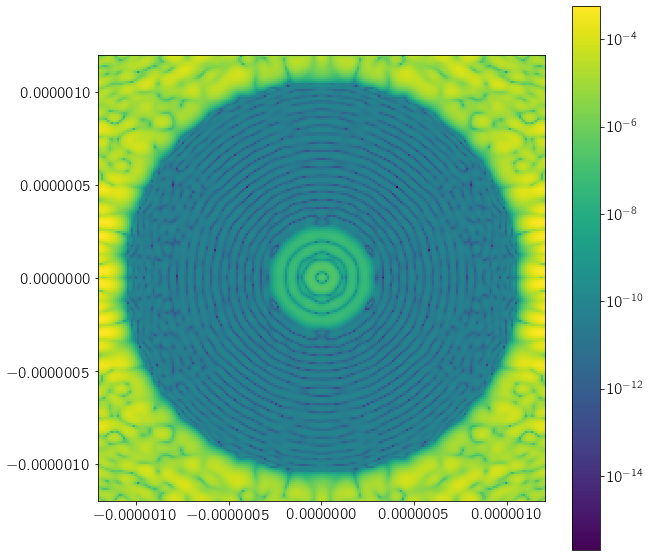

In [66]:
zernike_coeffs = mu_map*eunit/2
luvoir.fdm.actuators = zernike_coeffs
luvoir.fdm(luvoir.wf_aper)
psf, ref, inter = luvoir.calc_psf(ref=True, return_intermediate='efield')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf.intensity/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = np.abs(psf.electric_field - psf_unaber.electric_field)**2/norm 
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)])
print('contrast:', test_contrast)

In [67]:
# N_zernike = 5
# zernike_coeffs_numaps_Drifts = np.zeros([N_zernike,120])
# for qq in range(N_zernike):
#     zernike_coeffs_tmp = np.zeros([120])
#     for pp in range(120):
#         zernike_coeffs_tmp[pp] = mu_map[qq+(pp)*N_zernike]
#     zernike_coeffs_numaps_Drifts[qq] = zernike_coeffs_tmp

In [68]:
# N_zernike = 5
# zernike_coeffs_numaps = np.zeros([N_zernike,number_of_modes])
# for qq in range(N_zernike):
#     zernike_coeffs_tmp = np.zeros([number_of_modes])
#     for pp in range(120):
#         zernike_coeffs_tmp[qq+(pp)*N_zernike] = mu_map[qq+(pp)*N_zernike]
#     zernike_coeffs_numaps[qq] = zernike_coeffs_tmp

In [69]:
# # Instantiate LUVOIR
# sampling = 4
# apodizer_design = 'medium'
# # This path is specific to the paths used in the LuvoirAPLC class
# optics_input = '/Users/pueyo/PythonPackages/PASTIS/LUVOIR_delivery_May2019/'
# luvoirDUMMY = LuvoirAPLC(optics_input, apodizer_design, sampling)
# luvoirDUMMY.make_segment_zernike_primary(1)

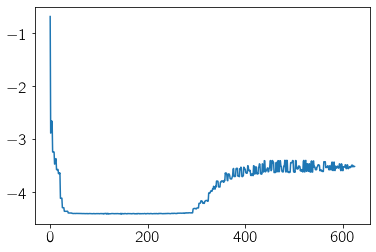

In [70]:
plt.plot(np.log10(mu_map))


In [71]:
# nu_maps = []
# for qq in range(luvoir.fdm.num_actuators):
zernike_coeffs = eunit*mu_map/2
luvoir.fdm.actuators = zernike_coeffs
trou = luvoir.fdm(luvoir.wf_aper).phase/luvoir.wf_aper.wavenumber
# nu_maps.append(luvoir.fdm(luvoir.wf_aper).phase/luvoir.wf_aper.wavenumber)

Text(0.5, 1, 'Segment')

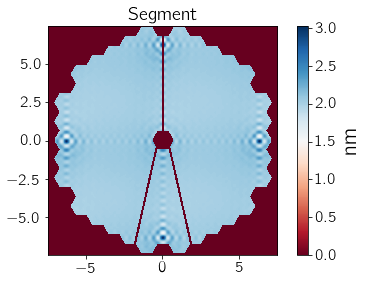

In [72]:
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(trou*10e9, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('nm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segment')

In [73]:
# nu_maps_Drifts = []
# for qq in range(N_zernike):
#     zernike_coeffs = eunit*zernike_coeffs_numaps_Drifts[qq]/2
#     luvoirDUMMY.sm.actuators = zernike_coeffs
#     nu_maps_Drifts.append(luvoirDUMMY.sm(luvoirDUMMY.wf_aper).phase/luvoirDUMMY.wf_aper.wavenumber/eunit)

# E2E histogram

In [74]:
number_of_modes

625

In [75]:
n_repeat = 30
all_contr_rand_seg = []
all_random_maps = []
for rep in range(n_repeat):
    print('Segment realization {}/{}'.format(rep + 1, n_repeat))
    #zernike_coeffs = np.random.uniform(-mu_map*eunit,mu_map*eunit,number_of_modes)
    zernike_coeffs = np.random.uniform(0,mu_map*eunit,number_of_modes)
    luvoir.fdm.actuators = zernike_coeffs
    luvoir.fdm(luvoir.wf_aper)
    psf, ref, inter = luvoir.calc_psf(ref=True, return_intermediate='efield')
#     plt.figure(figsize=(10, 10))
#     hc.imshow_field(psf.intensity/norm, norm=LogNorm())
#     plt.colorbar()
    dh_intensity = np.abs(psf.electric_field - psf_unaber.electric_field)**2/norm 
    test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)])
    all_contr_rand_seg.append(test_contrast) 
    print('contrast:', test_contrast)
    

Segment realization 1/30
contrast: 1.616929821397167e-10
Segment realization 2/30
contrast: 2.3753483741392195e-11
Segment realization 3/30
contrast: 7.58521977514516e-12
Segment realization 4/30
contrast: 7.282105300562954e-13
Segment realization 5/30
contrast: 1.494643627282419e-10
Segment realization 6/30
contrast: 1.043728919999716e-10
Segment realization 7/30
contrast: 1.1844306592068004e-11
Segment realization 8/30
contrast: 6.847261793490423e-13
Segment realization 9/30
contrast: 6.3441654160453755e-12
Segment realization 10/30
contrast: 7.101462757122847e-11
Segment realization 11/30
contrast: 3.596985218353525e-11
Segment realization 12/30
contrast: 1.816813658586845e-11
Segment realization 13/30
contrast: 6.874306010752851e-13
Segment realization 14/30
contrast: 3.562779079904174e-11
Segment realization 15/30
contrast: 7.386915142956647e-11
Segment realization 16/30
contrast: 1.8839213196023443e-11
Segment realization 17/30
contrast: 2.5376319198592512e-11
Segment realization

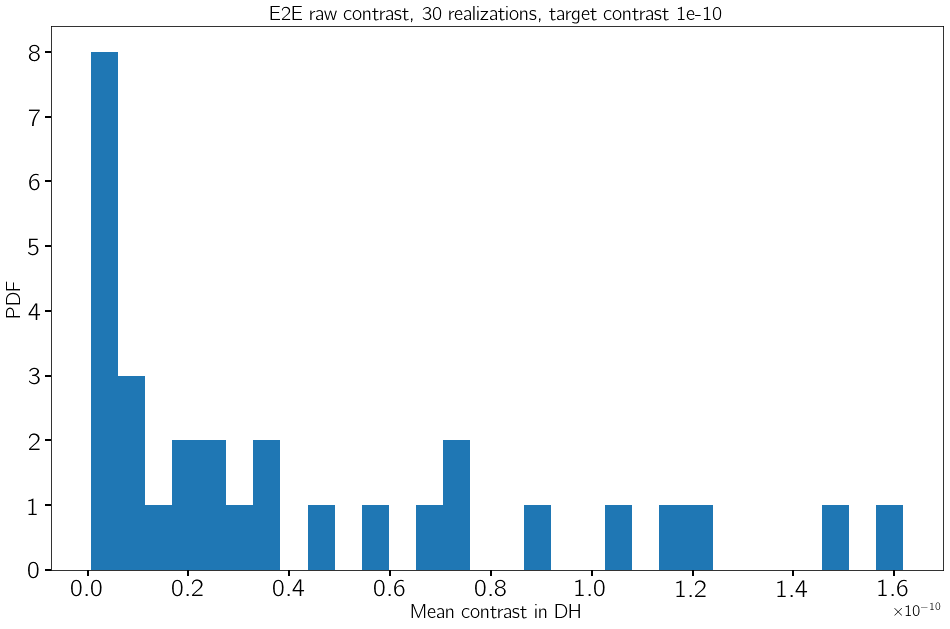

In [76]:
plt.figure(figsize=(16, 10))
plt.hist(all_contr_rand_seg,30)
plt.title('E2E raw contrast, {} realizations, target contrast 1e-10'.format(n_repeat), size=20)
plt.xlabel('Mean contrast in DH', size=20)
plt.ylabel('PDF', size=20)
plt.tick_params(axis='both', which='both', length=6, width=2, labelsize=25)

In [ ]:
x